In [ ]:
!pip install torchdiffeq

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

adjoint = True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import warnings

warnings.filterwarnings("ignore")

## DATA

In [ ]:
def lorenz_attractor(sigma, rho, beta, initial_state, num_steps=10000, dt=0.01):
    points = np.zeros((num_steps, 3))
    x, y, z = initial_state

    for step in range(num_steps):
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z

        x += dt * dx
        y += dt * dy
        z += dt * dz

        points[step] = [x, y, z]

    return points

def plot_lorenz_attractor(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(points[:, 0], points[:, 1], points[:, 2], lw=0.5)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Lorenz Attractor")
    plt.show()

def generate_lorenz_dataset(sigma, rho, beta, initial_state, num_trajectories=10, trajectory_length=10000, dt=0.01):
    dataset = np.zeros((num_trajectories * trajectory_length, 3))

    for i in range(num_trajectories):
        start_index = i * trajectory_length
        end_index = start_index + trajectory_length
        trajectory = lorenz_attractor(sigma, rho, beta, initial_state, num_steps=trajectory_length, dt=dt)
        dataset[start_index:end_index, :] = trajectory

    return dataset

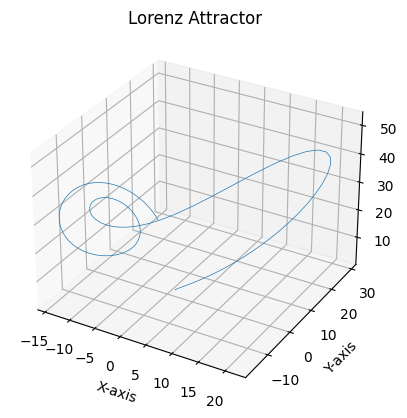

In [ ]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

initial_state = [1.0, 1.0, 1.0]

num_trajectories = 1
trajectory_length = 150
dt = 0.01
data = generate_lorenz_dataset(sigma, rho, beta, initial_state, num_trajectories, trajectory_length, dt)






plot_lorenz_attractor(data)

In [ ]:
data.shape

(150, 3)

# To spheric coordinates

In [ ]:
# import math
# def cartesian_to_spherical(coordinates):
#     spherical_coordinates = []
#     for point in coordinates:
#         x, y, z = point
#         r = math.sqrt(x**2 + y**2 + z**2)
#         theta = math.acos(z / r) if r != 0 else 0  # Избегаем деления на ноль
#         phi = math.atan2(y, x)
#         spherical_coordinates.append([r, theta, phi])
#     return np.array(spherical_coordinates)

# cartesian_coordinates = data
# data_new = cartesian_to_spherical(cartesian_coordinates)

In [ ]:
# plot_lorenz_attractor(data_new)

In [ ]:
# data = data_new

In [ ]:
data = data[:,0]

In [ ]:
data_size = int(data.shape[0]/2)

true_h0 = torch.tensor([data[0]]).float()
t = torch.linspace(0., dt*trajectory_length, data_size)


true_h = torch.tensor(data[:data_size]).unsqueeze(1).float()

print(true_h.shape)

torch.Size([75, 1])


In [ ]:
t

tensor([0.0000, 0.0203, 0.0405, 0.0608, 0.0811, 0.1014, 0.1216, 0.1419, 0.1622,
        0.1824, 0.2027, 0.2230, 0.2432, 0.2635, 0.2838, 0.3041, 0.3243, 0.3446,
        0.3649, 0.3851, 0.4054, 0.4257, 0.4459, 0.4662, 0.4865, 0.5068, 0.5270,
        0.5473, 0.5676, 0.5878, 0.6081, 0.6284, 0.6486, 0.6689, 0.6892, 0.7095,
        0.7297, 0.7500, 0.7703, 0.7905, 0.8108, 0.8311, 0.8514, 0.8716, 0.8919,
        0.9122, 0.9324, 0.9527, 0.9730, 0.9932, 1.0135, 1.0338, 1.0541, 1.0743,
        1.0946, 1.1149, 1.1351, 1.1554, 1.1757, 1.1959, 1.2162, 1.2365, 1.2568,
        1.2770, 1.2973, 1.3176, 1.3378, 1.3581, 1.3784, 1.3986, 1.4189, 1.4392,
        1.4595, 1.4797, 1.5000])

In [ ]:
test_t = torch.linspace(0., 2*dt*trajectory_length, data_size)
test_h = torch.tensor(data[::2]).unsqueeze(1).float()

print(test_h.shape)

torch.Size([75, 1, 3])


In [ ]:
index_range = np.arange(data_size)
def get_data(batch_time=32):
    t0 = np.random.choice(index_range[:-batch_time])
    idx = torch.tensor(np.array([t0 + i for i in range(batch_time)]))
    batch_h = true_h[idx]
    return batch_h[0], t[idx], batch_h

test_batch_h0, test_batch_t, test_batch_h = get_data()
test_batch_h0.shape, test_batch_t.shape, test_batch_h.shape

(torch.Size([1]), torch.Size([32]), torch.Size([32, 1]))

## ODE-Net

In [ ]:
class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(3, 16),
            # nn.ReLU(),
            # nn.BatchNorm1d(64, track_running_stats=False),  # Добавлен слой нормализации
            # nn.ELU(),
            # nn.Tanh() ,
            # nn.Linear(32,64) ,
            # nn.Tanh() ,
            nn.Linear(16, 32),
            # nn.Tanh() ,
            nn.Linear(32, 16),
            # nn.Tanh() ,
            # nn.Linear(128, 128),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.ELU()
            nn.Linear(16, 3),
        )

    def forward(self, t, h):
        return self.net(h)

In [ ]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, proj_dim = 0, num_layers = 1):
#         super(LSTM, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.out_dim = proj_dim if proj_dim > 0 else hidden_dim - 1
#         self.num_layers = num_layers
#         self.out2inp = nn.Linear(self.out_dim, input_dim)
#         self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, proj_size = self.out_dim)
#     def forward(self, x, t = None):
#         # device = next(self.parameters()).device
#         h_s, c_s = self.get_hidden(x.shape[0])
#         x = torch.permute(x, (2, 0 ,1))
#         output_, (h_s, c_s) = self.rnn(x , (h_s, c_s))
#         # print(output_.shape)
#         output_ = output_[None, :]
#         # print(output_.shape)

#         output_ = self.out2inp(output_)
#         output_ = output_.squeeze(3).permute(2,0,1)
#         return output_, 0, 0

#     def get_hidden(self, batch_size):
#         h0 = torch.zeros(1 * self.num_layers, batch_size, self.out_dim)
#         c0 = torch.zeros(1 * self.num_layers, batch_size, self.hidden_dim)
#         return h0, c0
# hidden_dim = 8
# LSTM_net = LSTM( input_dim = 1, hidden_dim= hidden_dim)
# x = torch.randn(10,1,3)
# out,_,_ = LSTM_net(x)
# print(out.shape)

In [ ]:
# class ode_func_interface(nn.Module):
#     def __init__(self, ):
#         super(ode_func_interface, self).__init__()
#         self.device = None
#     def compose_x_with_h(self, x, h): raise NotImplementedError()
#     def decompose_x_with_h(self, inp): raise NotImplementedError()
#     def inp2hid(self, t, x): raise NotImplementedError()
#     def forward(self, t , x): raise NotImplementedError()

# class LSTM_ODE_func(ode_func_interface):
#     def __init__(self, input_dim, hidden_dim, proj_dim = 0, num_layers = 1):
#         super(LSTM_ODE_func, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.out_dim = proj_dim if proj_dim > 0 else hidden_dim - 1
#         self.num_layers = num_layers
#         self.out2inp = nn.Linear(self.out_dim, input_dim)
#         self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, proj_size = self.out_dim)
#         self.device = torch.device("cpu")
#         self._inp2hid_ = nn.Linear(input_dim, hidden_dim * num_layers)
#         self.inp2out = nn.Linear(input_dim, self.out_dim * num_layers)

#     def compose_x_with_h(self, x, h,c):
#         x = torch.cat([x, *[h[i] for i in range(self.num_layers)],*[c[i] for i in range(self.num_layers)]], dim = -1)
#         return x.to(self.device)

#     def decompose_x_with_h(self, inp):
#         inp = inp.unsqueeze(0)
#         x = inp[..., : self.input_dim].to(self.device)
#         h_s = torch.cat(
#                 [ inp[..., self.input_dim + self.out_dim * i
#                         :self.input_dim + self.out_dim * (i + 1) ]
#                         for i in range(self.num_layers)], dim = 0 )
#         start_pos = self.input_dim + self.out_dim * self.num_layers
#         c_s = torch.cat(
#             [ inp[..., start_pos + self.hidden_dim* i:
#                     start_pos + self.hidden_dim*(i + 1)]
#                     for i in range(self.num_layers)], dim = 0 )
#         return x, [h_s.to(self.device), c_s.to(self.device)]

#     def inp2hid(self, t, x):
#         c = self._inp2hid_(x[..., 0])
#         c = torch.cat([c[..., self.hidden_dim * i : self.hidden_dim * (i + 1)].unsqueeze(0)
#             for i in range(self.num_layers)], dim = 0)
#         h = self.inp2out(x[..., 0])
#         h = torch.cat([h[..., self.out_dim * i : self.out_dim * (i + 1)].unsqueeze(0)
#             for i in range(self.num_layers)], dim = 0)
#         return [h.to(self.device), c.to(self.device)]

#     def forward(self, t, x):
#         device = next(self.parameters()).device
#         input_, [h_s, c_s] = self.decompose_x_with_h(x)
#         output_, (h_s, c_s) = self.rnn(input_ , (h_s, c_s))
#         output_ = output_.view(output_.shape[1:])
#         output_ = self.out2inp(output_)
#         return self.compose_x_with_h(output_, h_s, c_s)


# input_sequence = torch.randn(10, 1, 3)
# # print(input_sequence.shape)
# t = torch.arange(1,10,10).float()

# model = LSTM_ODE_func()
# predictions = model(input_sequence , t)

# print(predictions.shape)

In [ ]:
# test_batch_h.shape

In [ ]:
ODENet()(test_batch_t,test_batch_h).shape

torch.Size([32, 1, 3])

# Visual

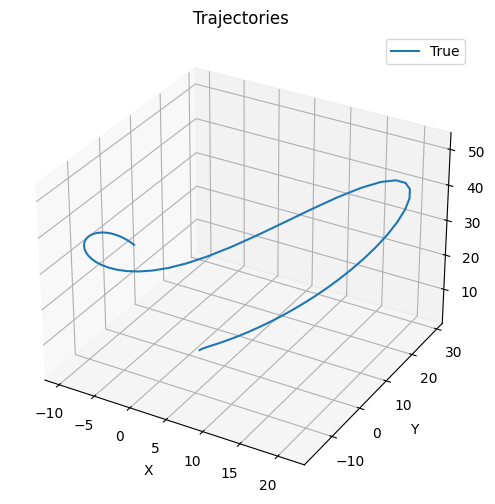

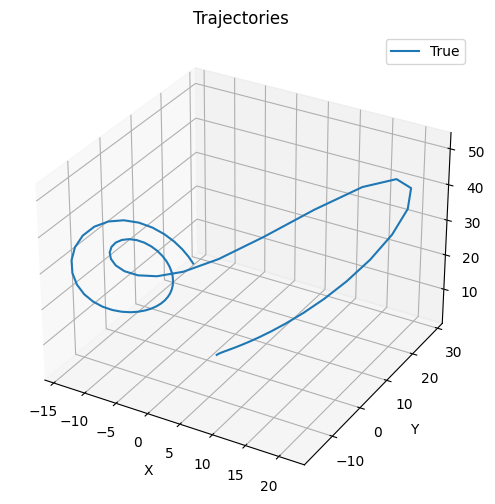

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d(true_h, pred_h=None):
    fig = plt.figure(figsize=(18, 6))

    # Subplot for trajectories
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(true_h[:, 0, 0], true_h[:, 0, 1], true_h[:, 0, 2], label='True')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Trajectories')
    ax1.legend()


    if pred_h is not None:
        ax1.plot(pred_h[:, 0, 0], pred_h[:, 0, 1], pred_h[:, 0, 2], '--', label='Predicted')

    plt.show()


visualize_3d(true_h)
visualize_3d(test_h)


## Train

In [ ]:
import tqdm

In [ ]:
func = ODENet()
optimizer = optim.Adam(func.parameters(),lr =1)#,weight_decay = 0.999)

In [ ]:
batch_h0 , batch_t ,batch_h

In [ ]:
niters = 2000
test_freq = 10

for itr in tqdm.tqdm(range(1, niters + 1)):
    optimizer.zero_grad()
    batch_h0, batch_t, batch_h = get_data(8)
    pred_h = odeint(func, batch_h0, batch_t)
    # print(pred_h.shape)
    loss = torch.mean(F.mse_loss(pred_h, batch_h))
    loss.backward()
    optimizer.step()

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_h = odeint(func, true_h0, t)
            loss = torch.mean(F.mse_loss(pred_h, true_h))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize_3d(true_h, pred_h.unsqueeze(1))


  0%|          | 1/2000 [00:35<19:36:49, 35.32s/it]


KeyboardInterrupt: ignored

# LSTM train

In [ ]:
class LSTM_func(nn.Module):
    def __init__(self):
        super(LSTM_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh() ,
            nn.Linear(50, 1),
        )

    def forward(self, t, h):
        return self.net(h)

In [ ]:
func = LSTM_func()
optimizer = optim.Adam(func.parameters(),lr =1)

In [ ]:
# true_h0.shape , t.shape , batch_h0.shape , batch_t.shape

  0%|          | 9/2000 [00:09<31:55,  1.04it/s]

Iter 0010 | Total Loss 110.661720


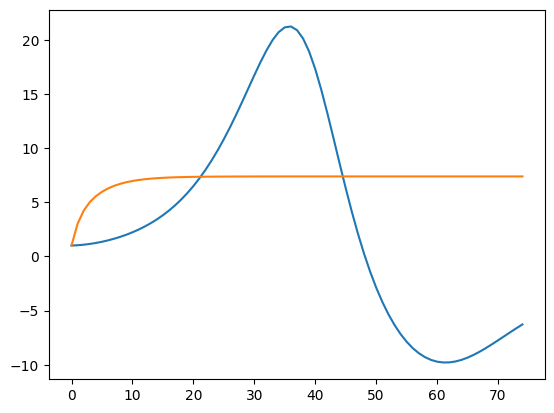

  1%|          | 19/2000 [00:18<30:28,  1.08it/s]

Iter 0020 | Total Loss 97.524544


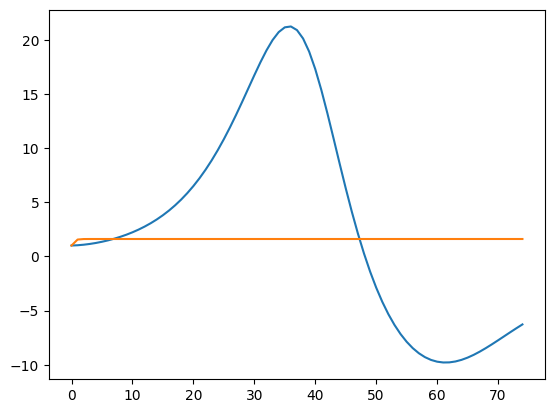

  1%|▏         | 29/2000 [00:47<1:28:08,  2.68s/it]

Iter 0030 | Total Loss 96.618973


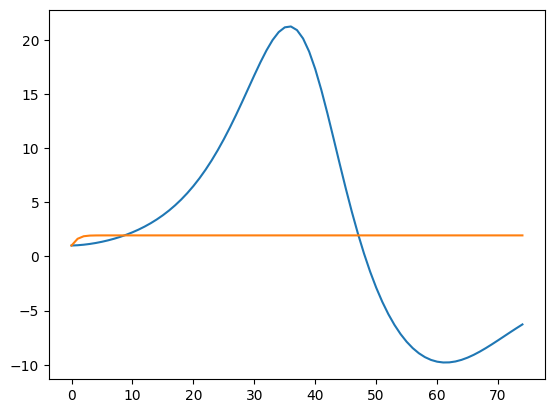

  2%|▏         | 31/2000 [00:52<55:50,  1.70s/it]  


KeyboardInterrupt: ignored

In [ ]:
niters = 2000
test_freq = 10

for itr in tqdm.tqdm(range(1, niters + 1)):
    optimizer.zero_grad()
    batch_h0, batch_t, batch_h = get_data()
    pred_h = odeint(func, batch_h0, batch_t)
    # print(pred_h.shape)
    loss = torch.mean(F.mse_loss(pred_h, batch_h))
    loss.backward()
    optimizer.step()

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_h = odeint(func, true_h0, t)
            loss = torch.mean(F.mse_loss(pred_h, true_h))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize_3d(true_h, pred_h.unsqueeze(1))
            # print(true_h.shape , pred_h.shape)
            plt.plot(true_h)
            plt.plot(pred_h.squeeze(1))
            plt.show()
